
# BDV & trends - longevity & EBL
**Goal:** This notebook tests whether EBL count correlates with max longevity



## 1) Compute body-mass–corrected longevity (log–log residuals)


In [2]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr

import re
import csv


OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ANAGE_CSV = "anage_fixed.csv"

# --- Load AnAge CSV ---
anage = pd.read_csv(ANAGE_CSV)

# Helper: fuzzy column matcher (ignores case, spaces, dots, parentheses)
def find_col(df, patterns):
    norm = {c: re.sub(r'[^a-z0-9]+', '', c.lower()) for c in df.columns}
    for pat in patterns:
        p = re.sub(r'[^a-z0-9]+', '', pat.lower())
        for c, n in norm.items():
            if p == n:
                return c
    # fallback: substring match
    for pat in patterns:
        p = re.sub(r'[^a-z0-9]+', '', pat.lower())
        for c, n in norm.items():
            if p in n:
                return c
    raise KeyError(f"Could not find any of {patterns} in columns:\n{df.columns.tolist()}")

# --- Handle naming inconsistencies first ---
# If the file uses Genus + Species, or only Common name, build a combined name column
if "Scientific name" not in anage.columns:
    if {"Genus", "Species"} <= set(anage.columns):
        anage["Scientific name"] = anage["Genus"].astype(str) + " " + anage["Species"].astype(str)
        print("Constructed Scientific name from Genus + Species.")
    elif "Common.name" in anage.columns:
        anage["Scientific name"] = anage["Common.name"]
        print("Used Common.name as Scientific name.")
    else:
        print("Warning: Could not find any name columns (Scientific name / Genus+Species / Common.name).")

# --- Now run the fuzzy column matcher ---
import re
def find_col(df, patterns):
    norm = {c: re.sub(r'[^a-z0-9]+', '', c.lower()) for c in df.columns}
    for pat in patterns:
        p = re.sub(r'[^a-z0-9]+', '', pat.lower())
        for c, n in norm.items():
            if p == n:
                return c
    for pat in patterns:
        p = re.sub(r'[^a-z0-9]+', '', pat.lower())
        for c, n in norm.items():
            if p in n:
                return c
    raise KeyError(f"Could not find any of {patterns} in columns:\n{df.columns.tolist()}")

# Find columns robustly (now 'Scientific name' exists)
class_col = find_col(anage, ["Class"])
order_col = find_col(anage, ["Order"])
name_col  = find_col(anage, ["Scientific name"])
mass_col  = find_col(anage, ["Adult weight (g)","Body.mass.g"])
life_col  = find_col(anage, ["Maximum longevity (yrs)","Maximum.longevity.yrs"])


# Keep mammals and needed cols
mammals = anage[anage[class_col].astype(str).str.contains("Mammalia", case=False, na=False)].copy()
mammals = mammals[[name_col, order_col, mass_col, life_col]].rename(columns={
    name_col: "Scientific name",
    order_col: "Order",
    mass_col: "Adult weight (g)",
    life_col: "Maximum longevity (yrs)"
})

# Coerce to numeric and clean
for c in ["Adult weight (g)", "Maximum longevity (yrs)"]:
    mammals[c] = pd.to_numeric(mammals[c], errors="coerce")

before = len(mammals)
mammals = mammals.dropna(subset=["Adult weight (g)", "Maximum longevity (yrs)"])
mammals = mammals[(mammals["Adult weight (g)"] > 0) & (mammals["Maximum longevity (yrs)"] > 0)].copy()
after_drop = len(mammals)

print(f"Kept {after_drop}/{before} rows after removing NaNs and nonpositive values.")

# Log-transform
mammals["log_mass"] = np.log10(mammals["Adult weight (g)"])
mammals["log_longevity"] = np.log10(mammals["Maximum longevity (yrs)"])

# Final NaN/inf guard
mammals = mammals.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_mass","log_longevity"])
print(f"Rows remaining for regression: {len(mammals)}")

# OLS: log10(longevity) ~ log10(mass)
X = sm.add_constant(mammals["log_mass"].values)
y = mammals["log_longevity"].values
ols = sm.OLS(y, X, missing="drop").fit()
mammals["Longevity_residual"] = y - ols.predict(X)

print(ols.summary())
mammals[["Scientific name","Order","Adult weight (g)","Maximum longevity (yrs)","Longevity_residual"]].head()

Constructed Scientific name from Genus + Species.
Kept 415/1330 rows after removing NaNs and nonpositive values.
Rows remaining for regression: 415
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           9.22e-66
Time:                        14:53:43   Log-Likelihood:                 1.5396
No. Observations:                 415   AIC:                            0.9208
Df Residuals:                     413   BIC:                             8.977
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0

,Scientific name,Order,Adult weight (g),Maximum longevity (yrs),Longevity_residual
1530,Echinops telfairi,Afrosoricida,116.4,19.0,0.308805
1532,Hemicentetes semispinosus,Afrosoricida,116.4,2.7,-0.538585
1533,Microgale dobsoni,Afrosoricida,44.6,5.6,-0.146527
1534,Microgale talazaci,Afrosoricida,44.0,5.8,-0.130225
1535,Setifer setosus,Afrosoricida,427.6,14.1,0.077225


 ## 2) EBL count


In [3]:
# Make sure the following edited EBL table with per-genus counts is in the same folder as this notebook. 

EBL_CSV = "EBL_counts_per_species_modified.csv"   

wide = pd.read_csv(EBL_CSV)


rename_map = {}
for col in list(wide.columns):
    lc = col.strip().lower().replace(" ", "_")
    if lc in {"host_species","hostspecies"}:        rename_map[col] = "Host_species"
    if lc in {"orthobornavirus","orthoborna"}:      rename_map[col] = "Orthobornavirus"
    if lc in {"carbovirus","carbo"}:                rename_map[col] = "Carbovirus"
    if lc in {"cultervirus","culter"}:              rename_map[col] = "Cultervirus"
    if lc in {"total","total_ebls","totalebls"}:    rename_map[col] = "Total_EBLs"
wide = wide.rename(columns=rename_map)

for needed in ["Host_species","Orthobornavirus","Carbovirus","Cultervirus"]:
    if needed not in wide.columns:
        wide[needed] = 0
if "Total_EBLs" not in wide.columns:
    wide["Total_EBLs"] = wide[["Orthobornavirus","Carbovirus","Cultervirus"]].sum(axis=1)

# Coerce counts to numeric
for c in ["Orthobornavirus","Carbovirus","Cultervirus","Total_EBLs"]:
    wide[c] = pd.to_numeric(wide[c], errors="coerce").fillna(0).astype(int)

print("wide:", wide.shape)
wide.head()

wide: (131, 5)


,Host_species,Carbovirus,Cultervirus,Orthobornavirus,Total_EBLs
0,Acanthisitta_chloris,1,0,0,1
1,Acinonyx_jubatus,6,0,0,6
2,Ailuropoda_melanoleuca,4,0,0,4
3,Aotus_nancymaae,8,5,8,21
4,Balaenoptera_acutorostrata,5,0,0,5



## 3) Merge EBL and AnAge data


In [4]:
import numpy as np

# "anage_fixed" must already exist


def norm_species(s):
    return re.sub(r"\s+", " ", str(s).replace("_"," ").strip()).lower()

wide["merge_key"] = wide["Host_species"].apply(norm_species)
mammals["merge_key"] = mammals["Scientific name"].apply(norm_species)

merged_ebl = pd.merge(
    wide,
    mammals[["merge_key","Scientific name","Order","Longevity_residual"]],
    on="merge_key",
    how="left"
)

# Optional: see unmatched species (present in EBL table but not in the AnAge subset)
unmatched = merged_ebl[merged_ebl["Scientific name"].isna()][["Host_species","Total_EBLs"]]
print("Unmatched EBL species (not found in the AnAge subset):", len(unmatched))
unmatched.head(10)

# Keep matched rows for plotting
plot_df = merged_ebl.dropna(subset=["Longevity_residual"]).copy()
print("Rows available for plotting:", len(plot_df))
plot_df.head()


Unmatched EBL species (not found in the AnAge subset): 26
Rows available for plotting: 106


,Host_species,Carbovirus,Cultervirus,Orthobornavirus,Total_EBLs,merge_key,Scientific name,Order,Longevity_residual
1,Acinonyx_jubatus,6,0,0,6,acinonyx jubatus,Acinonyx jubatus,Carnivora,-0.117043
2,Ailuropoda_melanoleuca,4,0,0,4,ailuropoda melanoleuca,Ailuropoda melanoleuca,Carnivora,0.062233
3,Aotus_nancymaae,8,5,8,21,aotus nancymaae,Aotus nancymaae,Primates,0.135137
4,Balaenoptera_acutorostrata,5,0,0,5,balaenoptera acutorostrata,Balaenoptera acutorostrata,Cetacea,-0.121922
5,Bison_bison,4,0,1,5,bison bison,Bison bison,Artiodactyla,-0.121541



## 4) longevity vs EBL count - MAIN CONTROL


=== Pure Longevity vs EBL Count ===
Pearson r = 0.335,  p = 0.0004
Spearman rho = 0.353, p = 0.0002
N species = 108


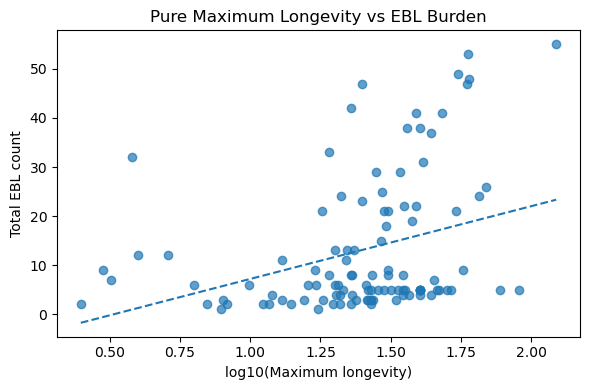

In [14]:
# === PURE LONGEVITY CONTROL ANALYSIS (robust version) ===
from scipy.stats import pearsonr, spearmanr

# Start from merged_ebl, which already merges the EBL table with AnAge names/orders
df = merged_ebl.copy()

# Add raw maximum longevity from the mammals dataframe based on Scientific name
df = df.merge(
    anage[["Scientific name", "Maximum.longevity.yrs"]],
    on="Scientific name",
    how="left"
)

# Keep only rows with both longevity and EBL data
df = df.dropna(subset=["Maximum.longevity.yrs", "Total_EBLs"])

# Log-transform longevity
df["log_longevity"] = np.log10(df["Maximum.longevity.yrs"])

# --- Correlations ---
pear_r, pear_p = pearsonr(df["log_longevity"], df["Total_EBLs"])
spear_r, spear_p = spearmanr(df["log_longevity"], df["Total_EBLs"])

print("=== Pure Longevity vs EBL Count ===")
print(f"Pearson r = {pear_r:.3f},  p = {pear_p:.4f}")
print(f"Spearman rho = {spear_r:.3f}, p = {spear_p:.4f}")
print(f"N species = {len(df)}")

# --- Plot ---
plt.figure(figsize=(6,4))
plt.scatter(df["log_longevity"], df["Total_EBLs"], alpha=0.7)

# Regression line
m, b = np.polyfit(df["log_longevity"], df["Total_EBLs"], 1)
xx = np.linspace(df["log_longevity"].min(), df["log_longevity"].max(), 100)
plt.plot(xx, m*xx + b, linestyle="--")

plt.xlabel("log10(Maximum longevity)")
plt.ylabel("Total EBL count")
plt.title("Pure Maximum Longevity vs EBL Burden")
plt.tight_layout()
plt.show()



## 5) EBL vs longevity residual


Total EBLs vs Longevity_residual — Spearman rho=0.446, p=1.706e-06


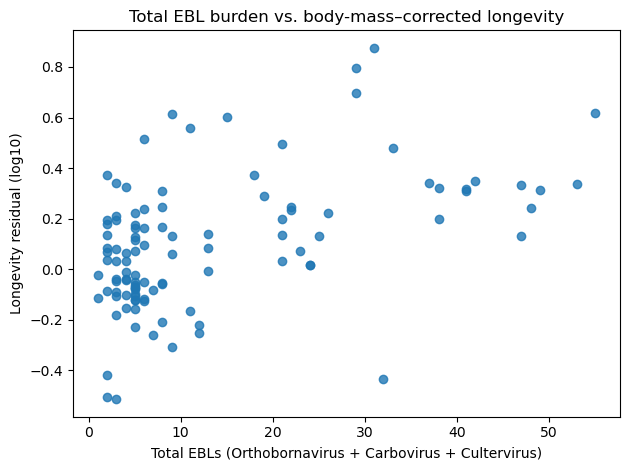

Orthobornavirus vs Longevity_residual — Spearman rho=0.340, p=3.570e-04


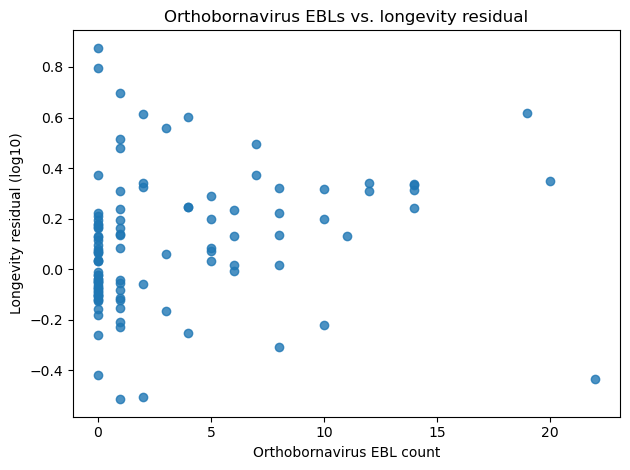

Carbovirus vs Longevity_residual — Spearman rho=0.352, p=2.117e-04


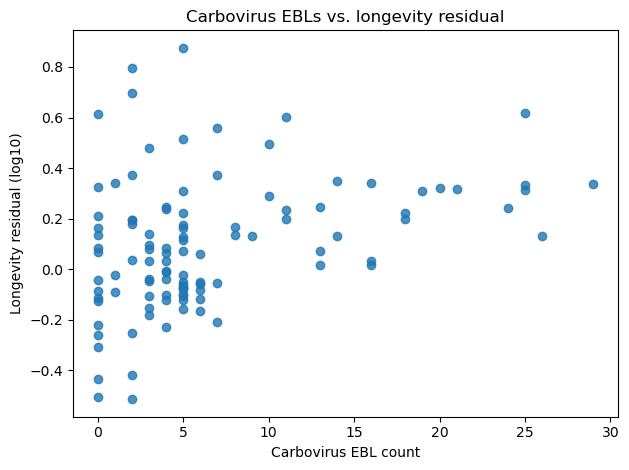

Cultervirus vs Longevity_residual — Spearman rho=0.458, p=7.876e-07


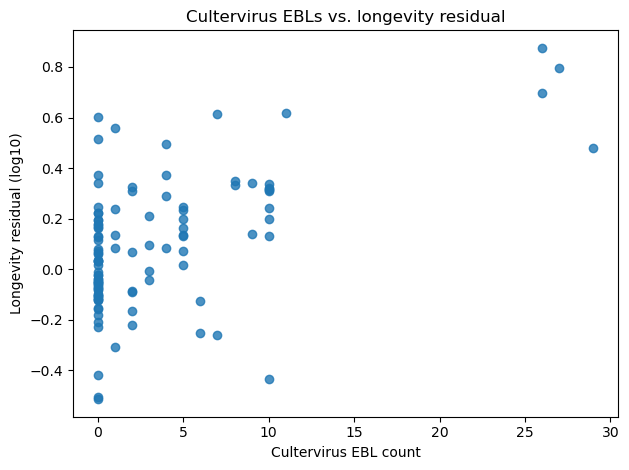

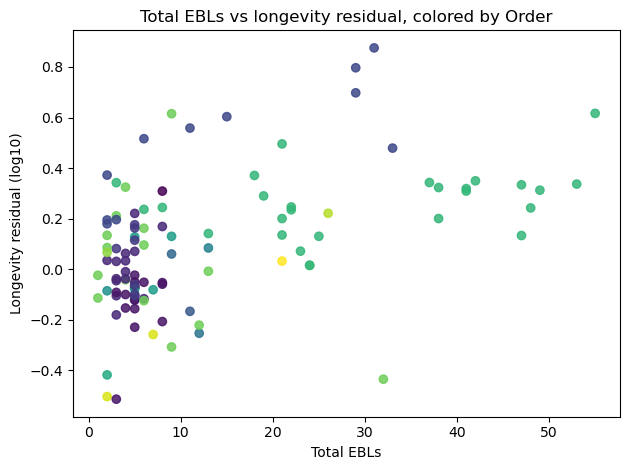

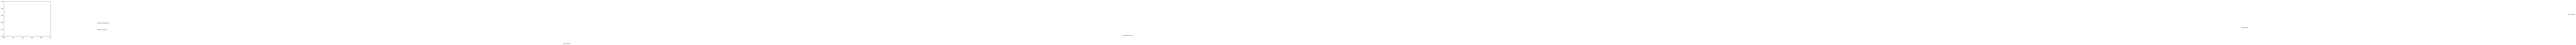

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1) Total EBLs vs. longevity residual
x = plot_df["Total_EBLs"].values
y = plot_df["Longevity_residual"].values
rho, p = spearmanr(x, y)
print(f"Total EBLs vs Longevity_residual — Spearman rho={rho:.3f}, p={p:.3e}")

plt.figure()
plt.scatter(x, y, alpha=0.8)
plt.xlabel("Total EBLs (Orthobornavirus + Carbovirus + Cultervirus)")
plt.ylabel("Longevity residual (log10)")
plt.title("Total EBL burden vs. body-mass–corrected longevity")
plt.tight_layout()
plt.show()

# 2) Per-genus scatter (small multiples: run separately)
for g in ["Orthobornavirus","Carbovirus","Cultervirus"]:
    xi = plot_df[g].values
    yi = plot_df["Longevity_residual"].values
    rho, p = spearmanr(xi, yi)
    print(f"{g} vs Longevity_residual — Spearman rho={rho:.3f}, p={p:.3e}")

    plt.figure()
    plt.scatter(xi, yi, alpha=0.8)
    plt.xlabel(f"{g} EBL count")
    plt.ylabel("Longevity residual (log10)")
    plt.title(f"{g} EBLs vs. longevity residual")
    plt.tight_layout()
    plt.show()



    # Simple color-by-order (categorical legend)
orders = plot_df["Order"].fillna("Unknown")
order_codes = {o:i for i,o in enumerate(sorted(orders.unique()))}
colors = orders.map(order_codes)

plt.figure()
plt.scatter(plot_df["Total_EBLs"], plot_df["Longevity_residual"], c=colors, alpha=0.85)
plt.xlabel("Total EBLs")
plt.ylabel("Longevity residual (log10)")
plt.title("Total EBLs vs longevity residual, colored by Order")
plt.tight_layout()
plt.show()

# Optional: label some canonical species if present
labels_to_show = {"Homo sapiens","Myotis myotis","Pteropus vampyrus","Loxodonta africana",
                  "Rousettus aegyptiacus","Gorilla gorilla","Mus musculus"}
for _, r in plot_df.iterrows():
    if r["Scientific name"] in labels_to_show:
        plt.text(r["Total_EBLs"], r["Longevity_residual"], r["Scientific name"], fontsize=8)

plt.show()



## 5b) Per Order


Orders available: ['Afrosoricida', 'Artiodactyla', 'Carnivora', 'Cetacea', 'Chiroptera', 'Dasyuromorphia', 'Dermoptera', 'Didelphimorphia', 'Diprotodontia', 'Erinaceomorpha', 'Perissodactyla', 'Pholidota', 'Primates', 'Proboscidea', 'Rodentia', 'Scandentia', 'Sirenia', 'Soricomorpha', 'Tubulidentata']


C:\Users\user\AppData\Local\Temp\ipykernel_39832\3349020039.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_ortho, p_ortho = spearmanr(sub["Orthobornavirus"], sub["Longevity_residual"])
C:\Users\user\AppData\Local\Temp\ipykernel_39832\3349020039.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_culte, p_culte = spearmanr(sub["Cultervirus"], sub["Longevity_residual"])


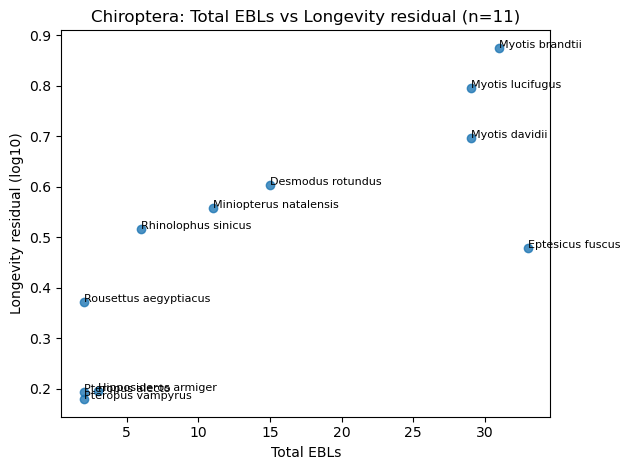

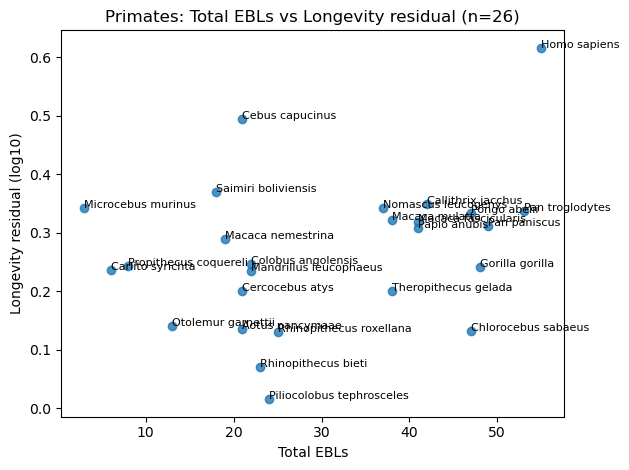

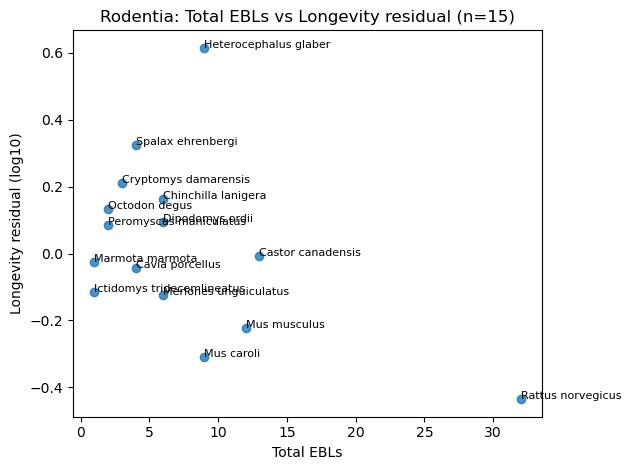

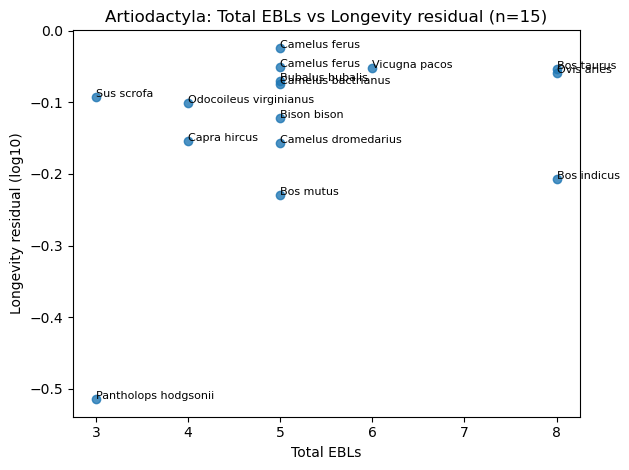

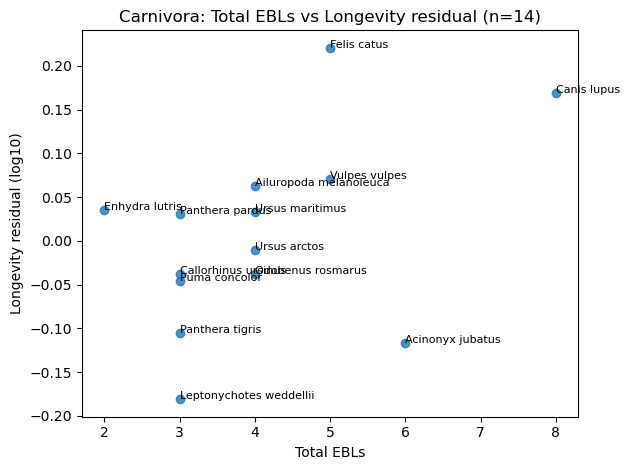

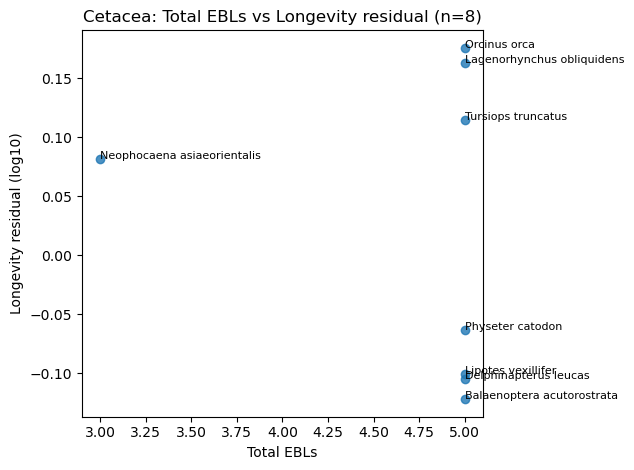

In [8]:
import pandas as pd
from scipy.stats import spearmanr


orders = sorted(plot_df["Order"].dropna().unique())
print("Orders available:", orders)

results = []
for order in orders:
    sub = plot_df[plot_df["Order"] == order]
    if len(sub) < 4:
        continue  # skip tiny orders

    rho_total, p_total = spearmanr(sub["Total_EBLs"], sub["Longevity_residual"])
    rho_ortho, p_ortho = spearmanr(sub["Orthobornavirus"], sub["Longevity_residual"])
    rho_carbo, p_carbo = spearmanr(sub["Carbovirus"], sub["Longevity_residual"])
    rho_culte, p_culte = spearmanr(sub["Cultervirus"], sub["Longevity_residual"])

    results.append({
        "Order": order,
        "N_species": len(sub),
        "ρ_total": rho_total, "p_total": p_total,
        "ρ_orthoborna": rho_ortho, "p_orthoborna": p_ortho,
        "ρ_carbo": rho_carbo, "p_carbo": p_carbo,
        "ρ_culter": rho_culte, "p_culter": p_culte
    })

pd.DataFrame(results)

import matplotlib.pyplot as plt



for order in ["Chiroptera", "Primates", "Rodentia", "Artiodactyla", "Carnivora", "Cetacea"]:
    sub = plot_df[plot_df["Order"] == order]
    if len(sub) < 4:
        continue


    plt.figure()
    plt.scatter(sub["Total_EBLs"], sub["Longevity_residual"], alpha=0.8)
    plt.xlabel("Total EBLs")
    plt.ylabel("Longevity residual (log10)")
    plt.title(f"{order}: Total EBLs vs Longevity residual (n={len(sub)})")

    # Label species
    for _, r in sub.nlargest(40, "Longevity_residual").iterrows():
        plt.text(r["Total_EBLs"], r["Longevity_residual"], r["Scientific name"], fontsize=8)

    plt.tight_layout()
    plt.show()
